# Kramer's Rate Evaluation of Quality of Collective Variables

Start this notebook with this command:
`env PYTHONPATH=$PATH_TO_MDFEATURE/mdfeature/src jupyter notebook`

e.g. `env PYTHONPATH=/home/dominic/PycharmProjects/mdfeature/src jupyter notebook`

In [1]:
%matplotlib inline
#import metadynamics
from openmm import *
from openmm.app import *
from openmm.unit import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as image
from pyemma import msm
from scipy.interpolate import griddata
from matplotlib.pyplot import cm
import mdtraj as md
from ipywidgets import IntProgress
from IPython.display import display
import time
import numpy as np
from autoimpute.imputations import MiceImputer, MultipleImputer, SingleImputer
import pandas as pd
from scipy.signal import find_peaks

import mdfeature.diffusionmap as diffusionmap

import mdfeature.fixed_point_iteration as fpi

from mdfeature.KramersRateEvaluator import KramersRateEvaluator

import dill

from scipy.optimize import dual_annealing

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Evaluation steps:
1. Generate a long MD simulation (or an ensemble of shorter replica simulations)
2. Apply diffusion maps and compute free energy $F(\xi)$
3. Divide by the diffusion coordinates into M boxes and calculate the transitions $C_{ij}$ over a specified time $t_{\alpha}$. 
4. Compute the most probable rate matrix $\mathbf{P}$ subject to a smoothness constraint on the diffusion coeffients. Compute the diffusion coefficients $D(\xi)$.
5. Identify the metastable states of interest, denoted $i$ and $j$, and compute the Kramer's rate of transition $\nu\left(i \rightarrow j\right)$.

## 1. Run Simulation

In [2]:
pdb_name = 'alanine.pdb'
save_name = 'trajectory.dcd'

steps = 100
iterations = 1000

temperature = 300 
R = 0.0083144621 # Universal Gas Constant kJ/K/mol
beta = 1.0/(temperature*R) # units (kJ/mol)**(-1)

friction_coefficient = 1.0/picosecond
stepSize = 0.002*picoseconds

def run_simulation(pdb_name, save_name, iterations, steps, temperature, force_fields=['amber14-all.xml', 'amber14/spce.xml']):
    pdb = PDBFile(pdb_name)

    forcefield = ForceField(*force_fields)
    system = forcefield.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic, constraints=HBonds)

    integrator = LangevinIntegrator(temperature*kelvin, friction_coefficient, stepSize)
    simulation = Simulation(pdb.topology, system, integrator, platform=Platform.getPlatformByName('CUDA'))
    simulation.context.setPositions(pdb.positions)
    simulation.context.setVelocitiesToTemperature(temperature*kelvin)

    mdinit = md.load_pdb(pdb_name)

    mdinit.save_dcd(save_name)     
    simulation.reporters.append(DCDReporter(save_name, steps, append=True))

    max_count = iterations
    bar = IntProgress(min=0, max=max_count) # instantiate the bar
    display(bar) # display the bar

    for i in range(iterations):
        bar.value += 1
        simulation.step(steps)
        state = simulation.context.getState(getEnergy=True, enforcePeriodicBox = False)
        positions = simulation.context.getState(getPositions=True).getPositions()
        
    return simulation

print('Simulation Time', 0.002*picoseconds*iterations)

Simulation Time 2.0 ps


In [3]:
mdinit = md.load_pdb(pdb_name)
#simulation = run_simulation(pdb_name='alanine.pdb', save_name='trajectory.dcd', iterations=iterations, steps=steps, temperature=temperature)

In [2]:
def open_trajectory_file(traj_file, skip_first=1000, use_test_trajectory=False):
    if use_test_trajectory:
        traj_file = 'test_traj.dcd'
    
    traj_std_tmp = md.load_dcd(traj_file, mdinit.topology)
    traj_orig = traj_std_tmp[skip_first:]
    traj_orig = traj_orig.superpose(traj_orig[0])
    
    return traj_orig

In [3]:
traj = open_trajectory_file(traj_file='trajectory_long.dcd', skip_first=10, use_test_trajectory=False)

NameError: name 'mdinit' is not defined

## 2. Apply Diffusion Maps And Compute $F(\xi)$

In [6]:
# Here we apply a target measure diffusion maps algorithm (TMDmap)

weight_params = {}
weight_params['simulation'] = simulation
weight_params['temperature'] = temperature

dmap_obj, traj_final = diffusionmap.compute_diffusionmaps(traj, nrpoints=None, epsilon=1.0, weights='compute', weight_params=weight_params)

Running diffusion maps with no subsampling.
<mdtraj.Trajectory with 999991 frames, 22 atoms, 3 residues, without unitcells>
Computing vanilla diffusionmap


In [2]:
#dill.dump(dmap_obj, file = open("dmap_extra_long.pickle", "wb"))
dmap_obj = dill.load(open("dmap_extra_long.pickle", "rb"))

/home/dominic/PycharmProjects/mdfeature/src/mdfeature/features.py:99: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(cos_theta) * np.sign(np.dot(rkj, np.cross(t, u)))


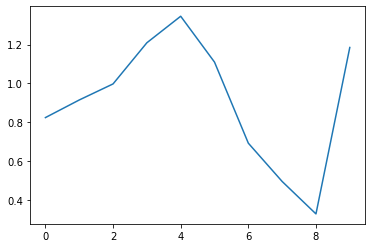

In [43]:
import mdfeature.features as features
psi = [6, 8, 14, 16]
psi_torsion = features.compute_torsion_mdraj(traj, psi)

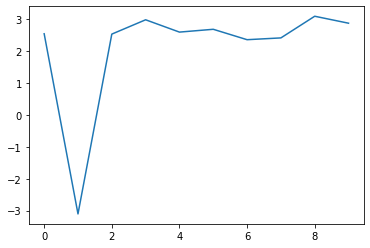

In [49]:
plt.plot(psi_torsion[30:40], label='psi')

In [20]:
diffusion_coordinate = 0 

def compute_marginalised_free_energy_from_diffusion_map(diffusion_map, diffusion_coordinate):
    free_energy_counts, coordinate = np.histogram(diffusion_map.dmap[:,diffusion_coordinate], bins=200)
    normalised_counts = free_energy_counts / np.sum(free_energy_counts)
    with numpy.errstate(divide='ignore'):
        free_energy = - (1/beta) * np.log(normalised_counts)
        
    for index, energy in enumerate(free_energy):
        if energy == np.inf or energy == -np.inf:
            free_energy[index] = np.nan
        
    return free_energy, coordinate[:-1]

Compute and iterpolate free energy

Text(0, 0.5, 'Free Energy (kJ/mol)')

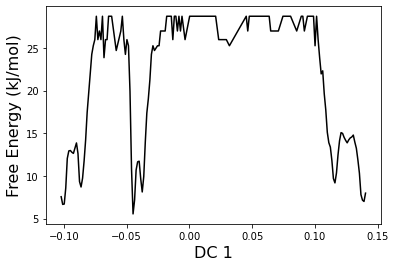

In [28]:
free_energy, coordinate = compute_marginalised_free_energy_from_diffusion_map(dmap_obj, diffusion_coordinate)

df = pd.DataFrame({'CV':coordinate, 'F':free_energy})
si = MiceImputer(return_list=True, strategy={"F": "interpolate"},n=1)
output = si.fit_transform(df)[0][1]

plt.plot(coordinate, output.F, 'k')
plt.xlabel('DC 1', fontsize=16)
plt.ylabel('Free Energy (kJ/mol)', fontsize=16)

Text(0, 0.5, 'log counts')

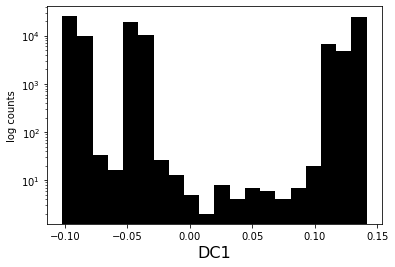

In [43]:
from matplotlib.pyplot import figure
diffusion_coordinate_time_series = dmap_obj.dmap[:,diffusion_coordinate]

plt.hist(diffusion_coordinate_time_series, bins=20, color='k')
plt.yscale('log')
plt.xlabel('DC1', fontsize=16)
plt.ylabel('log counts')

## 3. Partition Coordinates and Compute Counts Matrix $C_{ij}$

<font color='red'>TODO: better ways of partitioning the state space involving using k-means; PyEmma</font>

<font color='red'>TODO: make observational iternal on a $ps$ timescale</font>

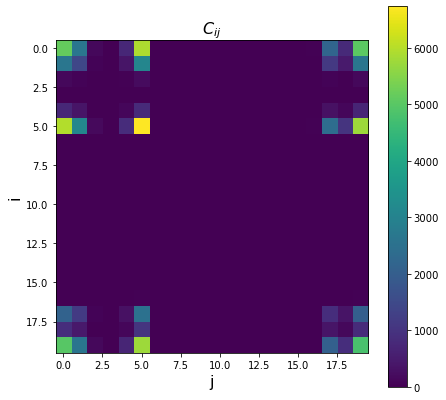

In [57]:
def compute_counts(time_series, observation_interval, cells):
    min_coord = min(time_series)
    max_coord = max(time_series)
    # the partitioning of the collective variable (here - uniform)
    X = [min_coord + (n+0.5) * (max_coord-min_coord)/cells for n in range(cells)]
    cell_sequence = []
    for coord in time_series:
        cell_sequence.append(round((cells-1)*(coord - min_coord)/(max_coord-min_coord)))

    N = np.zeros((cells, cells))
    state_sequence = [cell for idx, cell in enumerate(cell_sequence) if idx%observation_interval == 0]
    for idx, cell in enumerate(state_sequence[:-1]):
        N[cell, state_sequence[idx+1]]+=1
    
    P = np.zeros(cells)
    for state in cell_sequence:
        P[state] += 1
        
    P = P / np.sum(P)
        
    return N, P, X
    
t = 1    # the subsampling factor ("observation interval")
    
counts, P, Q = compute_counts(time_series=diffusion_coordinate_time_series, observation_interval=t, cells=20)
fig = plt.figure(figsize=(7,7))
plt.imshow(N)
plt.title(r'$C_{ij}$', fontsize=16)
plt.xlabel('j', fontsize=16)
plt.ylabel('i', fontsize=16)
plt.colorbar()
plt.show()

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

[1 4 6 ... 3 3 2]
[8 6 9 ... 0 0 3]
[-0.09972937 -0.09277868 -0.08539448 -0.04366348 -0.03706983  0.02766581
  0.11584612  0.12622796  0.13646516  0.13962831]


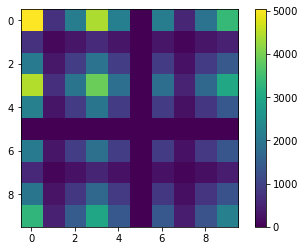

In [194]:
import pyemma

number_of_states = 8

cluster = pyemma.coordinates.cluster_kmeans(diffusion_coordinate_time_series, k=10, stride=5, max_iter=150)
discrete_traj = cluster.dtrajs[0]
cluster_centers = cluster.clustercenters

print(discrete_traj)

def relabel_trajectory_by_cluster_center(discrete_traj, cluster_centers):
    unique = np.unique(discrete_traj)
    number_of_states = len(unique)
    
    Q = np.zeros(number_of_states)
    for i in range(number_of_states):
        Q[i] = cluster_centers[i]
    
    sorted_Q = np.sort(Q)
    sorted_indices = np.argsort(np.argsort(Q))
    
    for idx, entry in enumerate(discrete_traj):
        discrete_traj[idx] = sorted_indices[discrete_traj[idx]]
        
    
    return discrete_traj, sorted_Q

traj, Q = relabel_trajectory_by_cluster_center(discrete_traj, cluster_centers)

print(traj)
    
# implied timescale analysis
#its = pyemma.msm.its(cluster.dtrajs, lags=[1, 2, 3, 5, 7, 10], nits=3, errors='bayes')
#pyemma.plots.plot_implied_timescales(its, ylog=False);

# check for Markovian behaviour
#bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=10, dt_traj='1 ps', conf=0.95)
#pyemma.plots.plot_cktest(bayesian_msm.cktest(4), units='ps');

def compute_C_matrix(discrete_trajectory, lag):
    unique = np.unique(discrete_trajectory)
    number_of_states = len(unique)
    C = np.zeros((number_of_states, number_of_states))
    for idx, state in enumerate(discrete_trajectory[:-lag]):
        C[state, discrete_trajectory[idx+lag]]+=1
        
    return C
    
print(Q)
counts = compute_C_matrix(traj, lag=1)
plt.imshow(counts)
plt.colorbar()

In [138]:
A = [-3, 2, -2, 0, 1, 0.5]
np.argsort(np.argsort(A))

array([0, 5, 1, 2, 4, 3])

## 4. Identify Most Probable $P_{ij}$ with Diffusion Coefficient Prior (Through Maximum Likelihood Optimisation)

Commented out code - click here -
<!---
def convert_R_components_to_matrix(R_components, P, matrix_dimension):
    R = np.zeros((matrix_dimension, matrix_dimension))
    component_number = 0
    for i in np.arange(0,matrix_dimension-1,1):
        n = matrix_dimension - i
        for j in range(i+1,i+n):
            R[i][j] = R_components[component_number]
            R[j][i] = R_components[component_number] * P[i] / P[j]
            component_number += 1
            
    row_sums = np.sum(R, axis=1)
    for i in range(matrix_dimension):
        R[i][i] = - row_sums[i]
        
    return R
                


def negative_log_likelihood(R, *args):
    # R is a 1D array
    N = args[0]
    P = args[1]
    t = args[2]
    number_of_cells = N.shape[0]

    R = convert_R_components_to_matrix(R, P, number_of_cells)
    P_half = P**(1/2)
    P_minus_half = P**(-1/2)
    
    # column-wise multiplication by a vector
    intermediate = np.multiply(R, P_half)
    # row-wise multiplication by a vector
    R_tilde = np.multiply(P_minus_half[:,np.newaxis], intermediate)
    Lambda, U = np.linalg.eig(R_tilde)
    #print("U")
    #print(U)
    e_tLambda = np.diag(np.exp(t * Lambda))
    #print("etLambda")
    #print(e_tLambda)
    e_tR_tilde = U @ e_tLambda @ U.transpose()
    #print("e_tR_tilde")
    #print(e_tR_tilde)
    e_tR = np.diag(P**(1/2)) @ e_tR_tilde @ np.diag(P**(-1/2))
    ln_e_tR = np.log(e_tR)
    #print(ln_e_tR)
    #input()
    
    nll = - np.sum(np.multiply(N, ln_e_tR))

    return nll
The rate matrix $\mathbf{R}$ must satisfy detailed balance: for a given probability vector $P$, we have that $\mathbf{R}$ has $N(N-1)/2$ free coefficients with matrix elements defined as:

$$
R_{ij} =
\begin{cases}
R_{ij} > 0 &\text{if}\; i>j \\
- \sum_{l\neq i}R_{li} &\text{if}\; i=j \\
R_{ji}P_i/P_j &\text{if}\; i < j
\end{cases}.
$$

Now define the symmetric matrix $\tilde{R}_{ij} = P^{-1/2}_i R_{ij} P_j^{1/2}$ whose matrix of real eigenvectors $U$ satisfies $\mathbf{\tilde{R}}\mathbf{U} = \mathbf{U}\mathbf{\Lambda}$, where $\mathbf{\Lambda}=\text{diag}\left(\lambda_1, ..., \lambda_N\right)$. It follows that $e^{t\mathbf{\tilde{R}}}=\mathbf{U}e^{t\mathbf{\Lambda}}\mathbf{U}^T$ and so $e^{t\mathbf{R}}=\text{diag}\left(P_1^{1/2}, ..., P_N^{1/2}\right)e^{t\mathbf{\tilde{R}}}\text{diag}\left(P_1^{-1/2},...,P_N^{-1/2}\right)$ which can be calculated by diagonalisation of the real symmetric matrix $\mathbf{\tilde{R}}$.

The log-likelihood function associated with the observed $N_{ij}$ for a given rate matrix $\mathbf{R}$ is then:

$$
\ln{L} = \sum_{i=1}^{m}\sum_{j=1}^m N_{ij} \ln{\left(e^{tR}\right)_{ij}}.
$$
<font color='red'>TODO: Compute the stationary distribution from the $P_i$; PyEmma</font>

It can be shown that the convex constrained optimisation problem:

$$
\text{minimise} - \sum_{i,j} c_{ij} \log{p_{ij}}
$$

subject to 

$$
p_{ij} \geq 0 \\
\sum_{j} p_{ij} = 1 \\
\pi_i p_{ij} = \pi_j p_{ji}
$$

can be solved by fixed-point iteration with solution

$$
p^*_{ij} = \frac{\left( c_{ij} + c_{ji}\right)\pi_i}{\lambda_i^*\pi_j + \lambda_j^*\pi_i}
$$

where the Lagrangian parameters $\lambda_i^*$ are obtained by iterating the following self-consistent equation to convergence

$$
\lambda_i^{(n+1)} = \sum_j \frac{\left(c_{ij}+c_{ji}\right) \pi_j \lambda_i^{(n)}}{\lambda_i^{(n)}\pi_j + \lambda_{j}^{(n)}\pi_i}.
$$
def update_lambda(old_lambda, counts, stationary_distribution):
    intermediate_matrix = np.zeros(counts.shape)
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            intermediate_matrix[i][j] = (counts[i][j] + counts[j][i])*(stationary_distribution[j]*old_lambda[i])/(old_lambda[i]*stationary_distribution[j] + old_lambda[j]*stationary_distribution[i])
            
    return np.sum(intermediate_matrix, axis=0)

def calculate_lagrangian_parameters(counts, stationary_distribution, err):
    lambda_vec = np.random.normal(size=counts.shape[0])
    current_error = float('inf')
    iterations = 0
    while current_error > err:
        new_lambda_vec = update_lambda(lambda_vec, counts, stationary_distribution)
        current_error = np.linalg.norm(new_lambda_vec-lambda_vec)
        lambda_vec = new_lambda_vec
        iterations += 1
        if iterations % 5 == 0:
            print(iterations)
    
    return lambda_vec
    
def calculate_rate_matrix(counts, stationary_distribution, err):
    lambda_vec = calculate_lagrangian_parameters(counts, stationary_distribution, err)
    
    rate_matrix = np.zeros(counts.shape)
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            rate_matrix[i][j] = (counts[i][j] + counts[j][i])*(stationary_distribution[i])/(lambda_vec[i]*stationary_distribution[j] + lambda_vec[j]*stationary_distribution[i])
            
    return rate_matrix

rate_matrix = calculate_rate_matrix(counts=N, stationary_distribution=P, err = 0.001)

stationary_distribution, rate_matrix_gamma = fpi.fit_markov_state_model(counts=N, coordinates=coordinate, gamma=0.0001, error=0.0001)

fig = plt.figure(figsize=(7,7))
plt.imshow(rate_matrix)
plt.title(r'$R_{ij}$', fontsize=16)
plt.xlabel('i', fontsize=16)
plt.ylabel('j', fontsize=16)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(7,7))
plt.imshow(rate_matrix_gamma.T)
plt.title(r'$R_{ij}$', fontsize=16)
plt.xlabel('i', fontsize=16)
plt.ylabel('j', fontsize=16)
plt.colorbar()
plt.show()
def update_lambda(old_lambda, counts, stationary_distribution):
    intermediate_matrix = np.zeros(counts.shape)
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            intermediate_matrix[i][j] = (counts[i][j] + counts[j][i])*(stationary_distribution[j]*old_lambda[i])/(old_lambda[i]*stationary_distribution[j] + old_lambda[j]*stationary_distribution[i])
            
    return np.sum(intermediate_matrix, axis=0)

def calculate_lagrangian_parameters(counts, stationary_distribution, err):
    lambda_vec = np.random.normal(size=counts.shape[0])
    current_error = float('inf')
    iterations = 0
    while current_error > err:
        new_lambda_vec = update_lambda(lambda_vec, counts, stationary_distribution)
        current_error = np.linalg.norm(new_lambda_vec-lambda_vec)
        lambda_vec = new_lambda_vec
        iterations += 1
        if iterations % 5 == 0:
            print(iterations)
    
    return lambda_vec
    
def calculate_rate_matrix(counts, stationary_distribution, err):
    lambda_vec = calculate_lagrangian_parameters(counts, stationary_distribution, err)
    
    rate_matrix = np.zeros(counts.shape)
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            rate_matrix[i][j] = (counts[i][j] + counts[j][i])*(stationary_distribution[i])/(lambda_vec[i]*stationary_distribution[j] + lambda_vec[j]*stationary_distribution[i])
            
    return rate_matrix

P = calculate_rate_matrix(counts=counts, stationary_distribution=P, err = 0.001)
--->

In [152]:
# Helper functions for inforcing symmetry contraints 

def random_initialise_symmetric_components(matrix_shape):
    # e.g. if matrix shape is (3,3) then produces a random vector of 6 components
    dim = int(matrix_shape[0] * (matrix_shape[0] + 1) / 2)
    x0 = np.random.uniform(size=dim)
    
    return x0

def get_symmetric_components_of_matrix(matrix):
    dim = matrix.shape[0]
    symmetric_components = []
    for i in range(dim):
        for j in range(dim):
            if j >= i:
                symmetric_components.append(matrix[i][j])
                
    return np.array(symmetric_components)


def construct_matrix_from_symmetric_components(symmetric_components):
    dim = int((-1+np.sqrt(1+8*symmetric_components.size))/2)
    matrix = np.zeros((dim, dim))
    for i in range(dim):
        for j in range(dim):
            if j >= i:
                matrix[i][j] = symmetric_components[int(i*dim - i*(i-1)/2 + j - i)]
                matrix[j][i] = matrix[i][j]  # symmetrise
                
    return matrix


# utility function for computing diffusion coefficient domain 
def domain_of_diffusion_coefficient(Q):
    Q_diff = []
    for i in range(len(Q)-1):
        Q_diff.append((Q[i+1]+Q[i])/2)
        
    return Q_diff

In [153]:
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

def compute_diffusion_coefficients(Q, X, x):
    D = np.zeros(len(Q) - 1)
    deltaQ2s = []
    for i in range(len(Q) - 1):
        deltaQ2 = (Q[i + 1] - Q[i]) ** 2
        D[i] = deltaQ2 * (X[i][i + 1]*X[i+1][i] / x[i]*x[i+1]) ** (0.5)
        deltaQ2s.append(deltaQ2)

    return D, np.mean(deltaQ2s)


def compute_diff_coeff_smoothness_penalty(D, gamma, Qvar):
    smoothness_penalty = 0
    for i in range(len(D) - 1):
        smoothness_penalty += (D[i] - D[i + 1]) ** 2 / (2 * (Qvar * gamma) ** 2)

    return smoothness_penalty


def negative_log_likelihood(X, counts, coordinates, gamma, use_smoothing, barrier_penalty=0.001):
    X = construct_matrix_from_symmetric_components(symmetric_components = X)
    x = np.sum(X, axis=1) #col sum

    if use_smoothing:
        D, Qvar = compute_diffusion_coefficients(Q, X, x)
        smoothness_penalty = compute_diff_coeff_smoothness_penalty(D, gamma, Qvar)
    else:
        smoothness_penalty = 0
        
    A = X/x
    
    barrier_function = barrier_penalty*(np.sum(- np.log(x))+np.sum(- np.log(1-x)))
    
    nll = float(- np.sum(counts * np.log(A)) + smoothness_penalty + barrier_function)

    return nll

/home/dominic/miniconda3/envs/diffusion/lib/python3.9/site-packages/scipy/optimize/_minimize.py:562: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
/home/dominic/miniconda3/envs/diffusion/lib/python3.9/site-packages/scipy/optimize/_constraints.py:368: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "
/tmp/ipykernel_110802/524320443.py:37: RuntimeWarning: invalid value encountered in log
  nll = float(- np.sum(counts * np.log(A)) + smoothness_penalty + barrier_function)


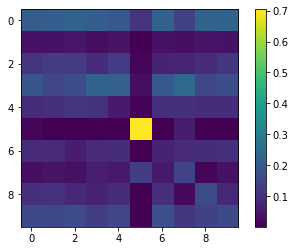

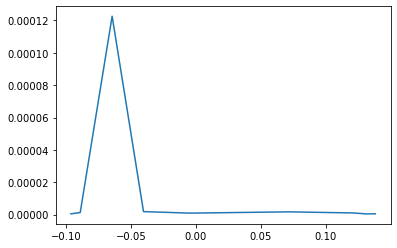

In [195]:
use_smoothing=True

number_of_parameters = int(counts.shape[0]*(counts.shape[0]+1)/2)
A = np.eye(number_of_parameters)
b = np.zeros(number_of_parameters)
lincon = LinearConstraint(A, b, np.inf*np.ones(number_of_parameters), keep_feasible=True)

# start from a position slightly perturbed from the optimal without a smoothness penalty
X0 = np.random.uniform(0., 0.05, size=(counts.shape))+((counts + counts.T)/(2*np.sum(counts)))
x0 = get_symmetric_components_of_matrix(X0)

#for gamma in [0.0000001, 0.00000005, 0.00000001, 0.000000005, 0.000000001]:
res = minimize(method='Nelder-Mead', fun=negative_log_likelihood, x0 = x0, args=(counts, Q, 0.01, use_smoothing), constraints=(lincon,), options={'maxiter': 20000})
X_star = construct_matrix_from_symmetric_components(res.x)
x_star = np.sum(X_star, axis=1)
pi_star = x_star/np.sum(x_star)
P_star = X_star/x_star
plt.imshow(P_star)
plt.colorbar()
D, Qvar = compute_diffusion_coefficients(Q, X_star, x_star)
plt.show()
plt.plot(domain_of_diffusion_coefficient(Q), D)
plt.show()

Finished in 1 iteration(s). Error 3.5e-06.


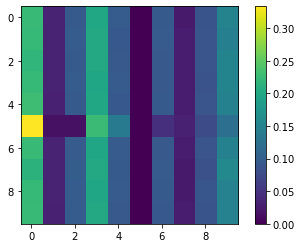

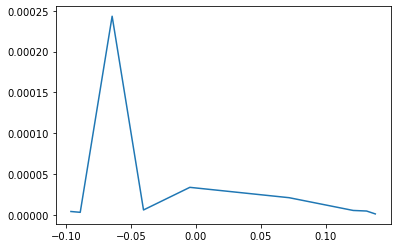

In [213]:
def compute_diffusion_coefficients_from_transition_matrix(Q, P):
    D = np.zeros(len(Q) - 1)
    deltaQ2s = []
    for i in range(len(Q) - 1):
        deltaQ2 = (Q[i + 1] - Q[i]) ** 2
        D[i] = deltaQ2 * (P[i][i + 1]*P[i+1][i]) ** (0.5)
        deltaQ2s.append(deltaQ2)

    return D, np.mean(deltaQ2s)

stationary_distribution, P = fpi.fit_markov_state_model(counts=counts, coordinates=coordinate, gamma=100, error=0.0001)

D, _ = compute_diffusion_coefficients_from_transition_matrix(Q, P)
plt.imshow(P)
plt.colorbar()
plt.show()
plt.plot(domain_of_diffusion_coefficient(Q), D)
plt.show()

## 6. Smoothing

Minima  (-0.088, 10.857)
Minima  (-0.041, 8.048)
Minima  (0.029, 25.51)
Minima  (0.115, 11.154)


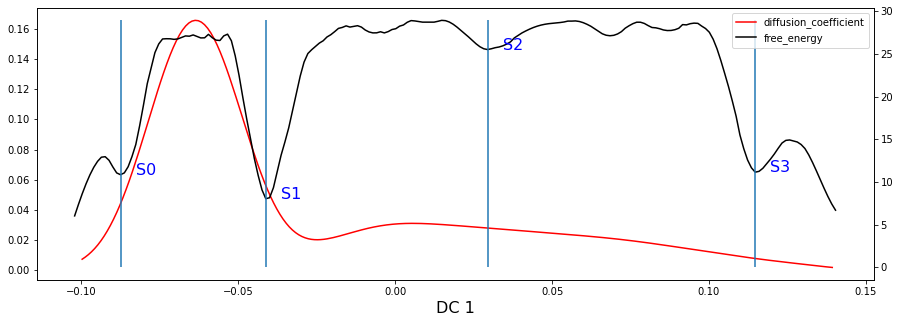

In [215]:
from scipy.signal import savgol_filter
import scipy.interpolate as interpolate



F_smoothed = savgol_filter(output.F, 15, 3)
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot()
l1, = ax1.plot(x_range, D_smoothed, color='red')
ax2 = ax1.twinx()
l2, = ax2.plot(coordinate, F_smoothed, color='k')

plt.legend([l1, l2], ["diffusion_coefficient", "free_energy"])

well_minima = find_peaks(-F_smoothed, prominence=2)
for idx, minima in enumerate(well_minima[0]):
    print("Minima ", (round(coordinate[minima],3), round(F_smoothed[minima],3)))
    plt.vlines(coordinate[minima], ymin = 0, ymax = max(F_smoothed))
    plt.text( coordinate[minima]+0.02*(max(coordinate)-min(coordinate)), F_smoothed[minima], f"S{idx}", fontsize=16, color='b')

ax1.set_xlabel('DC 1', fontsize=16)
plt.show()

Minima  (-0.041, -8.287)
Minima  (0.115, -7.041)


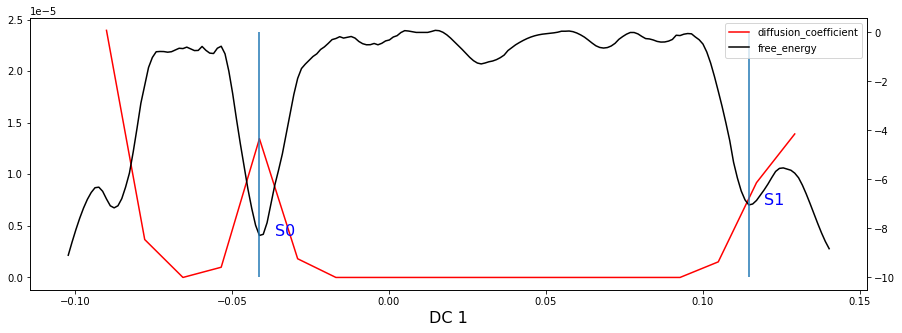

In [74]:
from scipy.signal import savgol_filter

D_smoothed = D #savgol_filter(D, 5, 3)
F_smoothed = savgol_filter(free_energy, 15, 3)
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot()
l1, = ax1.plot(Xd, D_smoothed, color='red')
ax2 = ax1.twinx()
l2, = ax2.plot(coordinate, F_smoothed, color='k')

plt.legend([l1, l2], ["diffusion_coefficient", "free_energy"])

well_minima = find_peaks(-F_smoothed, prominence=1.5)
for idx, minima in enumerate(well_minima[0]):
    print("Minima ", (round(coordinate[minima],3), round(F_smoothed[minima],3)))
    plt.vlines(coordinate[minima], ymin = -10, ymax = 0)
    plt.text( coordinate[minima]+0.02*(max(coordinate)-min(coordinate)), F_smoothed[minima], f"S{idx}", fontsize=16, color='b')

ax1.set_xlabel('DC 1', fontsize=16)
plt.show()

## 7. Compute the Kramer's Rate Along the Collective Variable Transection

<font color='red'>TODO: Figure out why this isn't invariant to adding arbitrary constant to $F(x)$</font>

Example: Calculating Kramer's rate for trasition $S1 \rightarrow S2$

Kramer's rate $\nu(i\rightarrow j)$ is given by

$$
\nu(i \rightarrow j) = \left( \int_{\mathcal{B_{ij}}} \frac{e^{\beta F(x)}}{D(x)} dx \int_{\mathcal{W}_{ij}} e^{- \beta F(x')} dx' \right)^{-1}
$$

where the barrier region $\mathcal{B}_{ij}$ is the segment of configurational space between (minima) states $i$ and $j$ and $\mathcal{W}_{ij}$ is the half of $\mathcal{B}_{ij}$ that is closer to state $i$.

In [217]:
import scipy.integrate as integrate

initial_state = 0
final_state = 1

ix = well_minima[0][initial_state]
jx = well_minima[0][final_state]
print(ix, jx)
midx = int(np.floor((ix+jx)/2))

def compute_well_integrand(beta, F):
    integrand = np.zeros(len(F))
    for x in range(len(F)):
        integrand[x] = np.exp(- beta * F[x])
    
    return integrand

def interpolate_function(x_coords, y_coords, x_to_evaluate):  
    x_min = min(x_coords)
    x_max = max(x_coords)
    
    if min(x_coords) <= x_to_evaluate <= max(x_coords):
        # interpolate
        x_low = max([x for x in x_coords if x <= x_to_evaluate])
        i_low = np.where(x_coords == x_low)
        x_high = min([x for x in x_coords if x > x_to_evaluate])
        i_high = np.where(x_coords == x_high)
        interpolation_distance = (x_to_evaluate - x_low)/(x_high - x_low)

        return y_coords[i_low] + (y_coords[i_high] - y_coords[i_low])*interpolation_distance 
    
    elif x_to_evaluate < x_min:
        # extrapolate
        return y_coords[0] - (x_min - x_to_evaluate)*(y_coords[1] - y_coords[0])/(x_coords[1] - x_coords[0])
        
    elif x_to_evaluate > x_max:
        # extrapolate
        return y_coords[-1] + (x_to_evaluate - x_max)*(y_coords[-1] - y_coords[-2])/(x_coords[-1] - x_coords[-2])

def compute_barrier_integrand(beta, F, D, coordinate):
    integrand = np.zeros(len(F))
    for x in range(len(F)):
        integrand[x] = np.exp(beta * F[x])/interpolate_function(x_range, D, coordinate[x])
    
    return integrand

well_integrand = compute_well_integrand(beta, F_smoothed)
    
well_integral = integrate.simps(well_integrand[ix:midx+1], coordinate[ix:midx+1])
print('Well integral: ', well_integral)


barrier_integrand = compute_barrier_integrand(beta, F_smoothed, D_smoothed, coordinate)
    
barrier_integral = integrate.simps(barrier_integrand[ix+1:jx], coordinate[ix+1:jx])
print('Barrier integral: ', barrier_integral)

kramers_rate = (barrier_integral * well_integral)**(-1)
print("Kramer's Rate: ", kramers_rate)

12 50
Well integral:  4.6219059956307225e-05
Barrier integral:  8717.605021878997
Kramer's Rate:  2.4818852828226157


# Whole Pipeline

In [3]:
temperature = 300 
beta = 1.0/(temperature*0.0083144621) # units kJ/mol

#dmap_obj = dill.load(open("dmap_long.pickle", "rb"))
diffusion_coordinate = 0
diffusion_coordinate_trajectory = dmap_obj.dmap[:,diffusion_coordinate]

Note: Of the 200 free energy evaluations, 1 were NaN values.


/home/dominic/PycharmProjects/mdfeature/src/mdfeature/KramersRateEvaluator.py:86: UserWarning: NaN values were found in the free energy calculation. Consider using a longer trajectory or rerunning with fewer bins (currently bins=200). Fixing with imputation for now.
  warnings.warn(f"NaN values were found in the free energy calculation. "


initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

MSM Implied Timescale Analysis


estimating MaximumLikelihoodMSM:   0%|                                                                        …

MSM Chapman-Kolmogorov Test


estimating MaximumLikelihoodMSM:   0%|                                                                        …

MSM created with 50 states, using lag time 12.


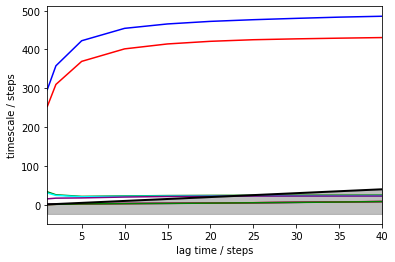

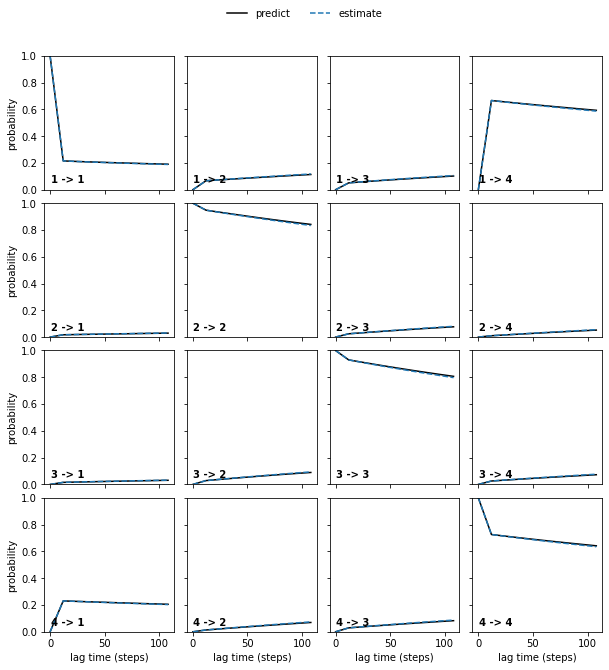

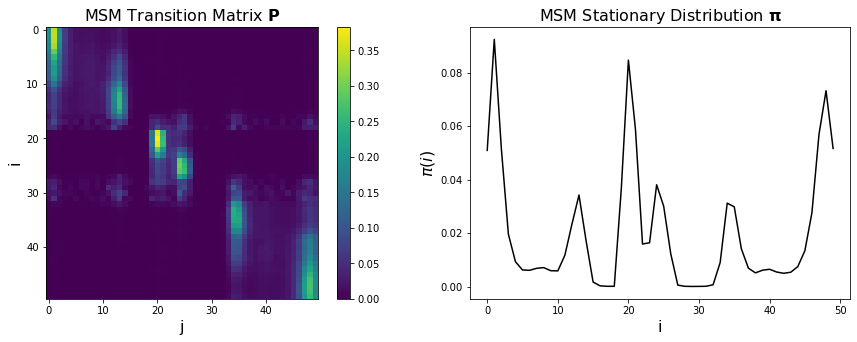

Free energy profile suggests 5 minima.
Minima  (-0.047, 3.602)
Minima  (-0.035, 8.75)
Minima  (-0.01, 6.651)
Minima  (-0.008, 8.222)
Minima  (0.041, 8.984)


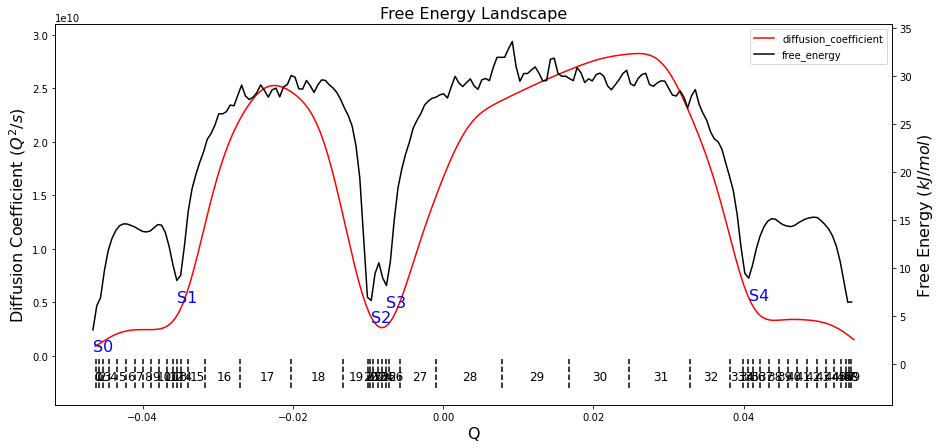

Kramer's Rates
-------------------------
S0 --> S1 : 6.153254e+12
S0 --> S2 : 5.994447e+10
S0 --> S3 : 5.991941e+10
S0 --> S4 : 8.702303e+09
S1 --> S0 : 2.790469e+13
S1 --> S2 : 5.019545e+11
S1 --> S3 : 5.015718e+11
S1 --> S4 : 1.908447e+10
S2 --> S0 : 2.442876e+11
S2 --> S1 : 2.302247e+11
S2 --> S3 : 1.534029e+15
S2 --> S4 : 5.082154e+10
S3 --> S0 : 1.126843e+11
S3 --> S1 : 1.133767e+11
S3 --> S2 : 1.671752e+15
S3 --> S4 : 2.195703e+11
S4 --> S0 : 1.190399e+11
S4 --> S1 : 1.230198e+11
S4 --> S2 : 1.576426e+11
S4 --> S3 : 1.577001e+11
-------------------------


In [7]:
kre = KramersRateEvaluator(verbose=True)

ps = 10**(-12)
rates = kre.fit(diffusion_coordinate_trajectory, 
                beta, 
                sigmaD=0.002,
                sigmaF=0.00025,
                lag = 12,
                bins=200, 
                step_size=0.002*ps,
                minima_prominance=2.0, 
                cluster_type='kmeans',
                options={'k': 50, 'stride': 5, 'max_iter': 150,
                 'max_centers': 1000, 'metric': 'euclidean', 'n_jobs': None, 'dmin': 0.002})

In [ ]:
from collections import defaultdict

def get_rate(start_state, end_state, rates):
    return [rate for rate in rates if rate[0][0] == start_state and rate[0][1] == end_state][0][1]

ks = [10,25,50,75,100,200]
dmins = [0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]

kre = KramersRateEvaluator()

rates_data = []

kre.fit(diffusion_coordinate_trajectory, 
        beta=1, 
        sigmaD=0.075,
        sigmaF=0.01,
        step_size=4e-2,
        lag=5,
        bins=300, 
        impute_free_energy_nans = False,
        minima_prominance=1.1, 
        include_endpoint_minima=False,
        cluster_type='kmeans',
        options={'k': 50, 'stride': 5, 'max_iter': 150,
         'max_centers': 20, 'metric': 'euclidean', 'n_jobs': None, 'dmin': 0.002})

In [ ]:
print(rates_data)